# Exporting QIIME2 data for PhyloSeq Analysis

###### Pedro J. Torres 2018

- By this point you should have already gone through most of your qiime2 tutorial. Files that are needed are:
1. Mapping File
2. unrooted-tree.qza
3. taxonomy.qza
4. table.qza

- This tutorial was made with help from the QIIME

In [1]:
# Export tree
!qiime tools export unrooted-tree.qza \
    --output-dir Phyloseq

In [6]:
# Export taxonomy
!qiime tools export taxonomy.qza \
    --output-dir Phyloseq

In [8]:
# Export table
!qiime tools export filtered-table.qza \
    --output-dir Phyloseq

In [17]:
%%bash
# Our Phyloseq folder should now have the following files
ls Phyloseq

feature-table.biom
sample-metadata.tsv
taxonomy.tsv
tree.nwk


### Next we will odify the exported taxonomy file's header before using it with BIOM software. 

In [19]:
%%bash
# This is what our current header looks like in our taxonomy file
head -n 2 Phyloseq/taxonomy.tsv

Feature ID	Taxon	Confidence
401bd8572d676efe34bb69cd84144424	Unassigned	0.9556681222602029


- The first line in our taxonomy file must be changes to 
#OTUID	taxonomy	confidence

In [20]:
%%bash
# Following script will change the first line of our file to desired header
sed 's/Feature ID/#OTUID/' Phyloseq/taxonomy.tsv | sed 's/Taxon/taxonomy/' | sed 's/Confidence/confidence/' > Phyloseq/biom-taxonomy.tsv

In [21]:
%%bash 
head -n 2 Phyloseq/biom-taxonomy.tsv

#OTUID	taxonomy	confidence
401bd8572d676efe34bb69cd84144424	Unassigned	0.9556681222602029


### Add the taxonomy data to your biom file

In [ ]:
%%bash
biom add-metadata \
    -i Phyloseq/feature-table.biom \
    -o Phyloseq/table-with-taxonomyv2.biom \
    --observation-metadata-fp Phyloseq/biom-taxonomy.tsv \
    --sc-separated taxonomy 

In [1]:
%%bash
#change into our Phyloseq directory
cd Phyloseq
ls

biom-taxonomy.tsv
feature-table.biom
sample-metadata.tsv
table-with-taxonomy.biom
taxonomy.tsv
tree.nwk


## Now that we have the necessary files we will hop onto [Phyloseq](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0061217)

In [1]:
# Install and load R pakcages that are necessary for the analysis - Packages are collections of R functions, data, 
# and compiled code in a well-defined format. Remove the hash sign to download and install the packages.

#source('http://bioconductor.org/biocLite.R')
#biocLite('phyloseq')
library("phyloseq")
packageVersion("phyloseq")

#biocLite("biomformat")
library("biomformat")
packageVersion("biomformat")

#install.packages("ggplot2")
library("ggplot2")
packageVersion("ggplot2")

#install.packages("vegan")
library("vegan")
packageVersion('vegan')

#install.packages("grid")
library("grid")
packageVersion('grid')

#install.packages("magrittr")
library(magrittr)
packageVersion('magrittr')

library(dplyr)
packageVersion('dplyr')

library(plyr)
packageVersion('plyr')

library(broom)
packageVersion('broom')

library('stringr')
packageVersion('stringr')

[1] ‘1.19.1’

[1] ‘1.2.0’

[1] ‘2.2.1’

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-6


[1] ‘2.4.6’

[1] ‘3.4.1’

[1] ‘1.5’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] ‘0.7.4’

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



[1] ‘1.8.4’

[1] ‘0.4.3’

[1] ‘1.2.0’

## Load Data into PhyloSeq Object

In [2]:
#add biome table, tree and metadata
biom_data <- import_biom(BIOMfilename = "table-with-taxonomyv2.biom", 
                         treefilename = "tree.nwk")
mapping_file <- import_qiime_sample_data(mapfilename = "sample-metadata.tsv")

# if the above script doesn't work, try including the full file path not just the file name

In [8]:
# Merge the OTU and mapping data into a phyloseq object
physeq <- merge_phyloseq(biom_data, mapping_file)
#Add names to biom table and check phyloseq objects
colnames(tax_table(physeq))= c("Kingdom","Phylum","Class","Order","Family","Genus", "Species")
rank_names(physeq)

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

[1] "Number of Samples in our Biom Table"


[1] 158

[1] "Number of Sequence variants we have."


[1] 481

[1] "Sequencing depth."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    843    2392    4358    4569    6356   10737 

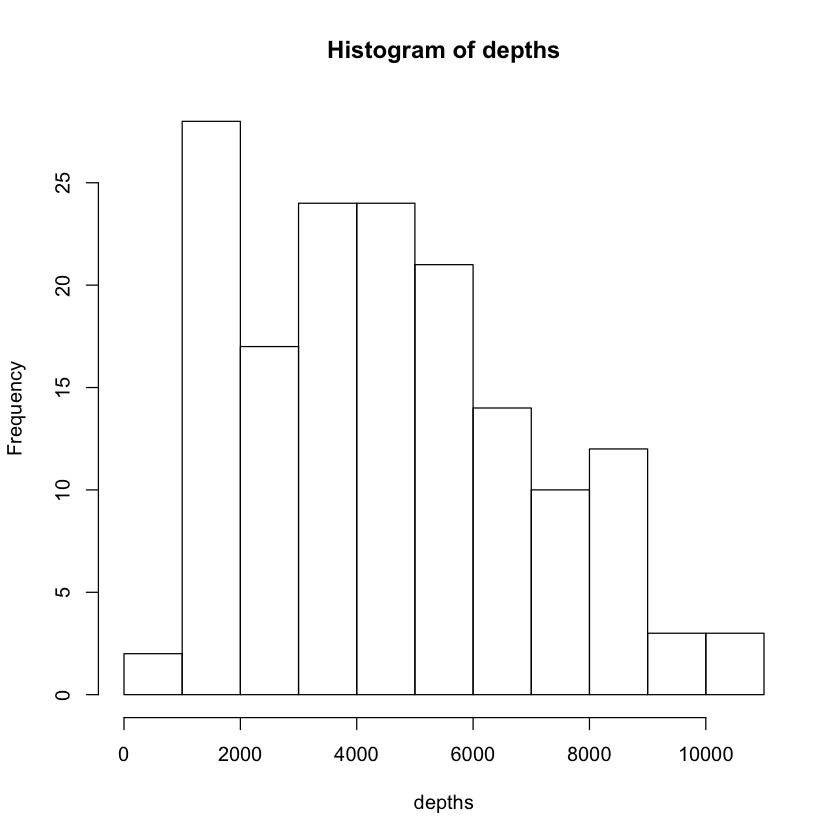

In [9]:
# Start to explore the data a bit 
#number of samples
print ('Number of Samples in our Biom Table')
nsamples(physeq)
# number of sequence variants
print ('Number of Sequence variants we have.')
ntaxa(physeq)
#summary statistics of sampling depth
print ('Sequencing depth.')
depths <- sample_sums(physeq)
summary(depths)
hist(depths)

# We see that we have a sample with a very low sequencing depth of 19 we will remove this sample

# Bargraphs

In [14]:
physeq
head(sample_data(physeq))
summary(sample_data(physeq)$PCOS_Control_PCOM)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 481 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 34 sample variables ]
tax_table()   Taxonomy Table:    [ 481 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 481 tips and 480 internal nodes ]

,X.SampleID,BarcodeSequence,pielou_e,shannon,observed_otus,faith_pd,Category,PCOS_Control_PCOM,PCOS_Control,PCOM_Control,⋯,X17_OHP,Age,BMI,Hirsutism,Testosterone_ng_mL,Oligomenorrhea,Hyperandrogenism,Polycystic_Ovarian_Morphology,Sequence_Count,Description
1,1,TCCCTTGTCTCC,0.9358485,3.902418,18,3.841920,PCOS,PCOS,PCOS,NA,⋯,1.970,34,24.8,8,0.26,No_Oligo,Hyperandrogenism,PCO_ovaries,15853,1
100,100,CTGCTATTCCTC,0.9503171,5.249135,46,7.144480,Control,PCOM,NA,PCOM,⋯,0.900,25,24.1,2,0.42,No_Oligo,No_Hyperandrogenism,PCO_ovaries,29848,100
101,101,ATGTCACCGCTG,0.8103452,4.122601,34,5.276004,Control,Control,Control,Control,⋯,1.200,24,19.4,1,0.33,No_Oligo,No_Hyperandrogenism,No_PCO_ovaries,43068,101
102,102,TGTAACGCCGAT,0.9014462,4.133097,24,5.218419,Control,PCOM,NA,PCOM,⋯,0.900,32,19.9,3,0.21,No_Oligo,No_Hyperandrogenism,PCO_ovaries,16310,102
103,103,AGCAGAACATCT,0.9399756,5.358274,52,7.787784,Control,Control,Control,Control,⋯,0.820,33,31.7,4,0.43,No_Oligo,No_Hyperandrogenism,No_PCO_ovaries,46943,103
104,104,TGGAGTAGGTGG,0.9003187,3.427833,14,3.186753,Control,Control,Control,Control,⋯,0.754,27,20.6,3,0.25,No_Oligo,No_Hyperandrogenism,No_PCO_ovaries,8827,104


Control    PCOM    PCOS 
     47      41      70

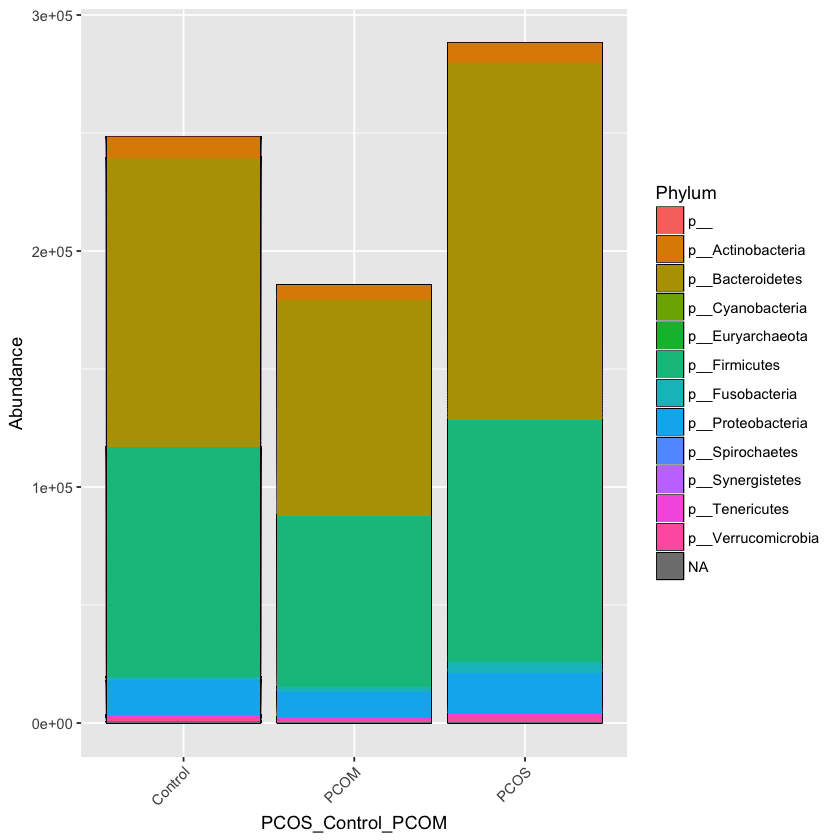

In [15]:
p<-plot_bar(physeq, x="PCOS_Control_PCOM", fill="Phylum")+theme(axis.text.x = element_text(angle = 45, hjust = 1))
p + geom_bar(stat = "identity", position = "stack")

# Lets get percent relative abudance

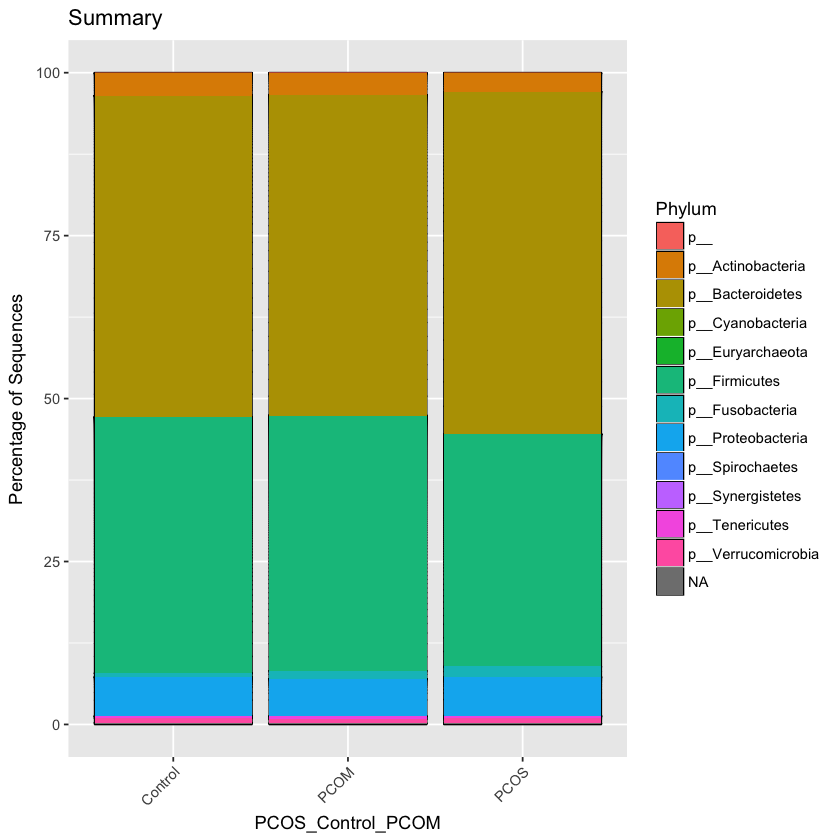

In [17]:
##############
#--------merge samples based on PCOS_Control_PCOM
#############

#DNA---------
#If you dont merge your percent abudnace will accumulate in a per sample basis
physeq.P.C.PM = merge_samples(physeq, "PCOS_Control_PCOM")

#Repair the merged values associated with each surface after merge. 
sample_data(physeq.P.C.PM)$PCOS_Control_PCOM <- levels(sample_data(physeq)$PCOS_Control_PCOM)

#transform to percent total abudnance
physeq.P.C.PM.percent = transform_sample_counts(physeq.P.C.PM, function(x) 100 * x/sum(x))
    
#percent abundance plot
p<-plot_bar(physeq.P.C.PM.percent, x="PCOS_Control_PCOM", fill="Phylum",title = "Summary")+theme(axis.text.x = element_text(angle = 45, hjust = 1))
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")

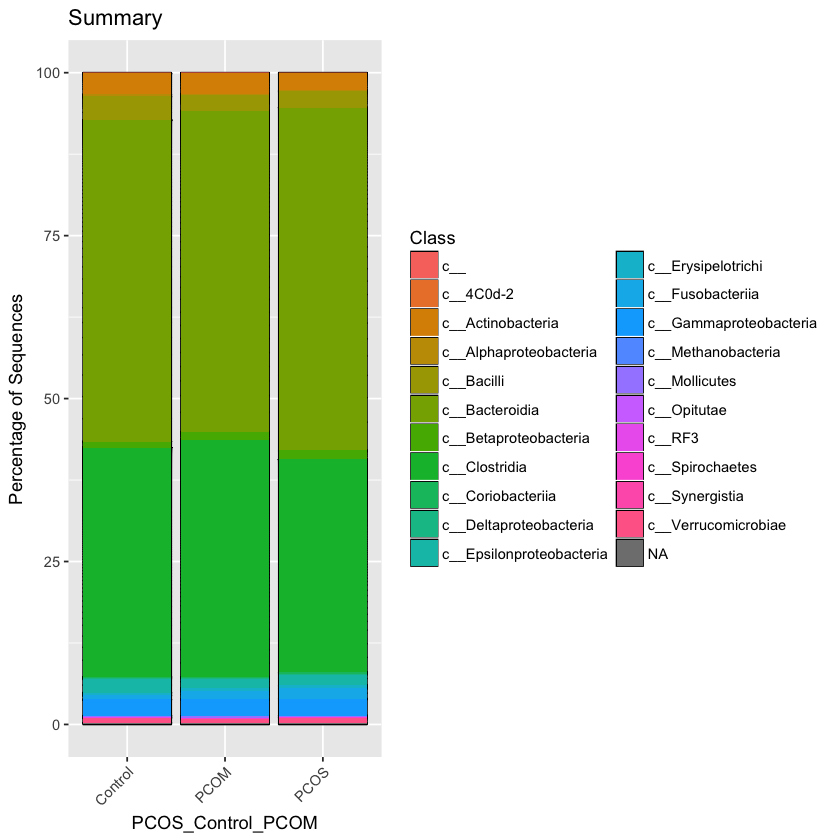

In [19]:
#percent abundance plot changed to whatever taxonomic level you want
p<-plot_bar(physeq.P.C.PM.percent, x="PCOS_Control_PCOM", fill="Class",title = "Summary")+theme(axis.text.x = element_text(angle = 45, hjust = 1))
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")

# What if we just look at the top 20 abundant bacteria

In [20]:
#first we sort the data
TopNOTUsdna = names(sort(taxa_sums(physeq.P.C.PM.percent), TRUE)[1:20])
#prune those OTUs
top20 = prune_taxa(TopNOTUsdna, physeq.P.C.PM.percent)
top20

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20 taxa and 3 samples ]
sample_data() Sample Data:       [ 3 samples by 34 sample variables ]
tax_table()   Taxonomy Table:    [ 20 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 20 tips and 19 internal nodes ]

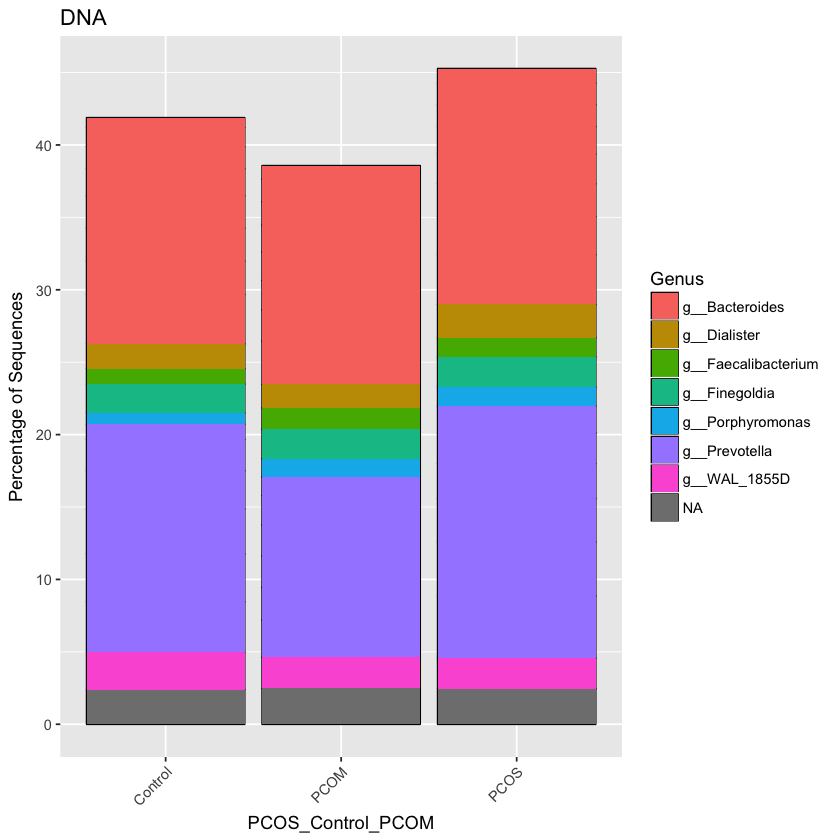

In [24]:

#percent abundance plot 
p<-plot_bar(top20, x="PCOS_Control_PCOM", fill="Genus",title = "DNA")+theme(axis.text.x = element_text(angle = 45, hjust = 1))
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")

# Alpha and Beta diversity Metrics¶
## Data must be normalized and or rarefied prior to analysis

In [25]:
# It is always important to set a seed when you subsample so your result is replicable . Here we will be 
# subsampling libraries with replacement 
set.seed(123)

for (i in 1:100) {
  # Subsample
    
  physeq.rarefy <- rarefy_even_depth(physeq, sample.size = 800, verbose = FALSE, replace = TRUE)
}

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 481 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 34 sample variables ]
tax_table()   Taxonomy Table:    [ 481 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 481 tips and 480 internal nodes ]

Warning message:
“Removed 10 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 800 rows containing missing values (geom_errorbar).”

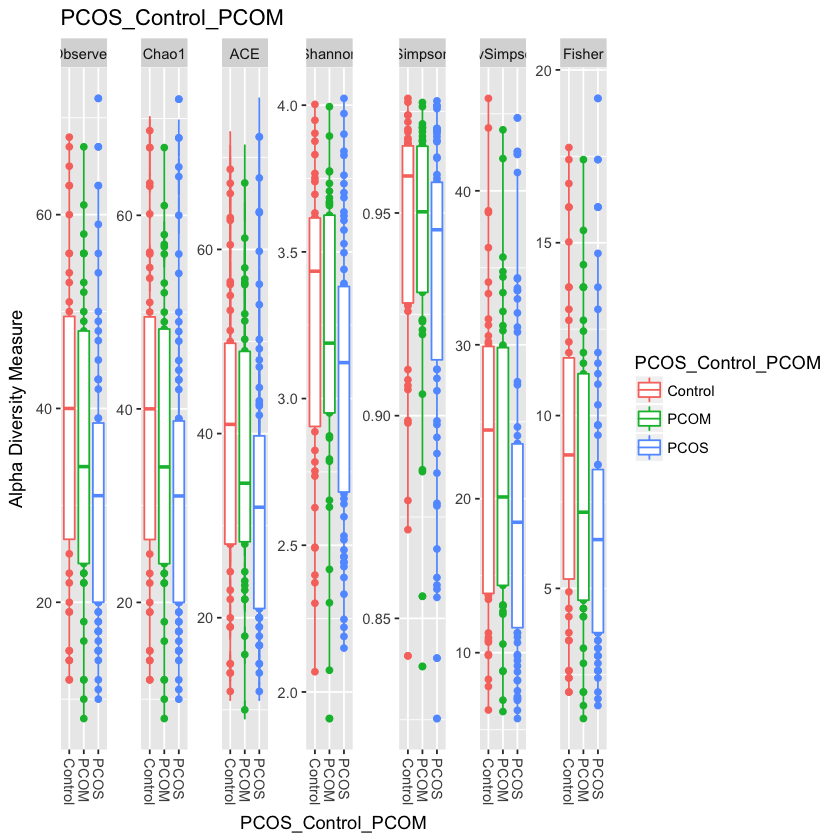

In [26]:
physeq.rarefy
plot_richness(physeq.rarefy, x = "PCOS_Control_PCOM", color='PCOS_Control_PCOM') + geom_boxplot()+ggtitle('PCOS_Control_PCOM')

# Betadiversity and PERMANOVA

# First we will use unconstrained ordination

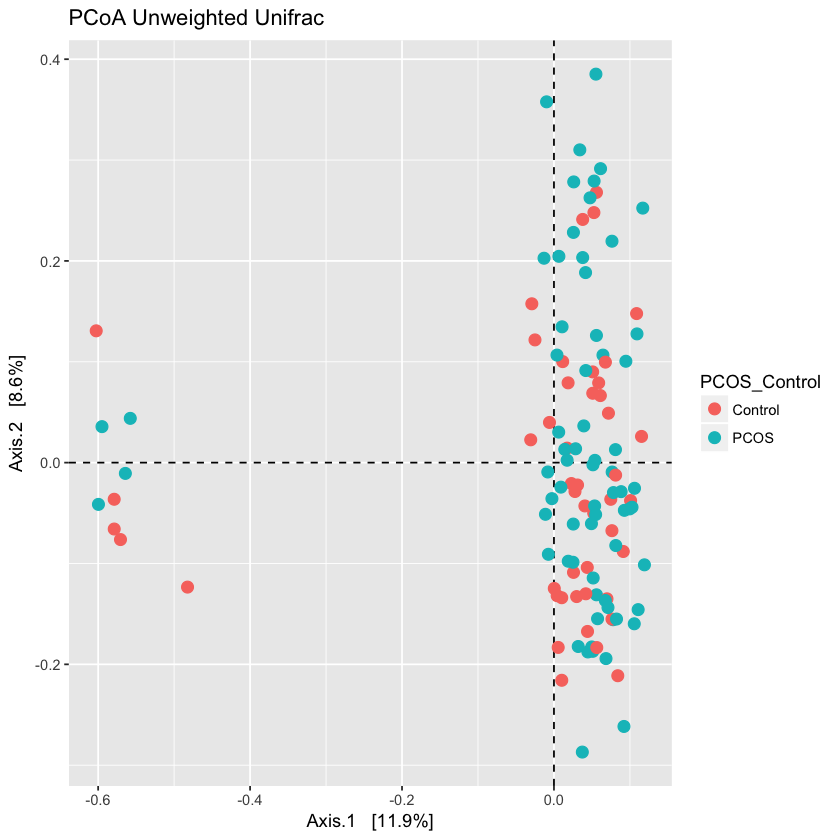

In [75]:
# Remove samples in the PCOM category. We are now working with the Phyloseq objects we made in the beginning
pcosrarefied=subset_samples(physeq.rarefy, PCOS_Control != 'PCOM')
#Get ordinaiton
pcoa.mds.uwuni <- ordinate(physeq = pcosrarefied, method = "PCoA", distance="unifrac", weighted=FALSE)
#Plot
p.pcoa.uwuni=plot_ordination(
  physeq = pcosrarefied, 
  ordination = pcoa.mds.uwuni, 
  color = "PCOS_Control"
) + geom_hline(yintercept=0, linetype=2) + geom_vline(xintercept=0,linetype=2)+
  geom_point(size = 3) + 
  ggtitle("PCoA Unweighted Unifrac")
p.pcoa.uwuni

# That is why we explore the data. We see a very different cluster of a set of patients. Do not know why this is so we will filter these out as we continue our analysis

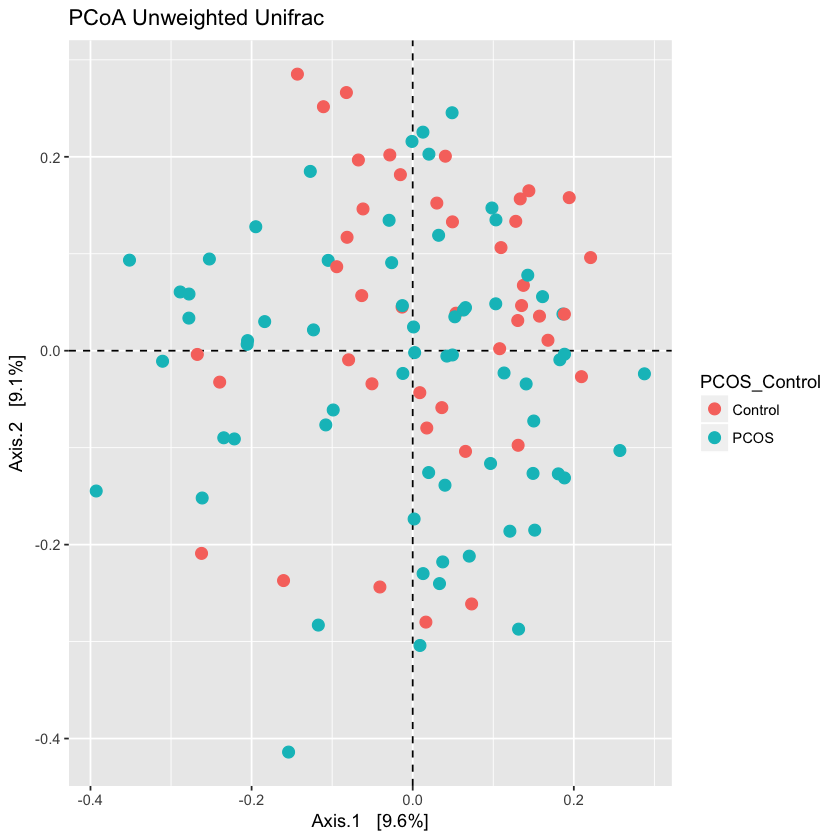

In [77]:
# Remove those samples that were clustering on the right side above (outsiders)
pcos.rare.nout=subset_samples(pcosrarefied,  X.SampleID != "93" & X.SampleID != "80" & X.SampleID != "39" & X.SampleID != "145" & X.SampleID != "172" & X.SampleID != "157" & X.SampleID != "163" & X.SampleID !="138")
#Get Ordination
pcoa.mds.uwuni <- ordinate(physeq = pcos.rare.nout, method = "PCoA", distance="unifrac", weighted=FALSE)
#Plot
p.pcoa.uwuni=plot_ordination(
  physeq = pcosrarefied, 
  ordination = pcoa.mds.uwuni, 
  color = "PCOS_Control"
) + geom_hline(yintercept=0, linetype=2) + geom_vline(xintercept=0,linetype=2)+
  geom_point(size = 3) + 
  ggtitle("PCoA Unweighted Unifrac")
p.pcoa.uwuni

### Permutational multivariate analysis of variance (PERMANOVA), is a non-parametric multivariate statistical test. PERMANOVA is used to compare groups of objects and test the null hypothesis that the centroids and dispersion of the groups as defined by measure space are equivalent for all groups. PERMANOVA allows us to see the effect that these variables have on the betadiversity. We can ask a similar question to the alpha diversity and regression models: what patient clinical parameter could be driving microbial composition?

In [78]:
df = as(sample_data(pcos.rare.nout), "data.frame") # this is our mapping file inside our phyloseq object being converted to a dataframe
d = phyloseq::distance(pcos.rare.nout, "unifrac", weighted=FALSE) # distance matrix

set.seed(2)
a=adonis(d ~ PCOS_Control_PCOM+LH+FSH+Age+BMI+Hirsutism+Testosterone_ng_mL+Menses_per_year+Hyperandrogenism+Polycystic_Ovarian_Morphology+Oligomenorrhea, df, permutations=1000, method='unifrac', weighted=FALSE)
a$aov.tab

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
PCOS_Control_PCOM,1,0.3038075,0.3038075,1.3367282,0.012385651,0.082917083
LH,1,0.2761555,0.2761555,1.2150616,0.011258330,0.155844156
FSH,1,0.1952791,0.1952791,0.8592119,0.007961153,0.688311688
Age,1,0.2220207,0.2220207,0.9768727,0.009051357,0.479520480
BMI,1,0.1761454,0.1761454,0.7750253,0.007181110,0.839160839
Hirsutism,1,0.1886741,0.1886741,0.8301505,0.007691881,0.743256743
Testosterone_ng_mL,1,0.2321536,0.2321536,1.0214570,0.009464459,0.432567433
Menses_per_year,1,0.2289112,0.2289112,1.0071903,0.009332269,0.400599401
Hyperandrogenism,1,0.4607920,0.4607920,2.0274471,0.018785607,0.000999001
Polycystic_Ovarian_Morphology,1,0.2178540,0.2178540,0.9585396,0.008881488,0.519480519


# Now we use constrained ordination

### CCA - We can hypothesis that the bacterial communities structure in these women is associated with androgen levels. CCA allows us to describe and visualize if an environmental variable or combination of, are strongly related to community composition.

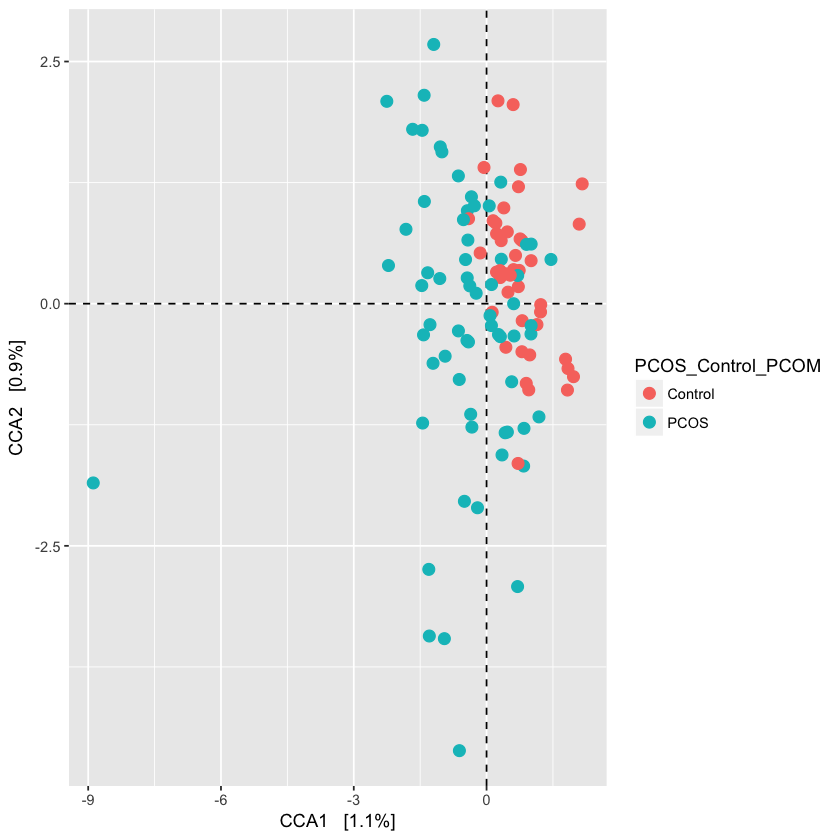

In [79]:
cca_lit = ordinate(pcos.rare.nout, ~ Hirsutism+Hyperandrogenism+Testosterone_ng_mL , method="CCA", distance = "unifrac")
p0 = plot_ordination(pcos.rare.nout, cca_lit, color = "PCOS_Control_PCOM")+ geom_hline(yintercept=0, linetype=2) + geom_vline(xintercept=0,linetype=2)+
  geom_point(size = 3) 
p0

Warning message:
“Ignoring unknown aesthetics: shape, label”Warning message:
“Ignoring unknown aesthetics: shape”

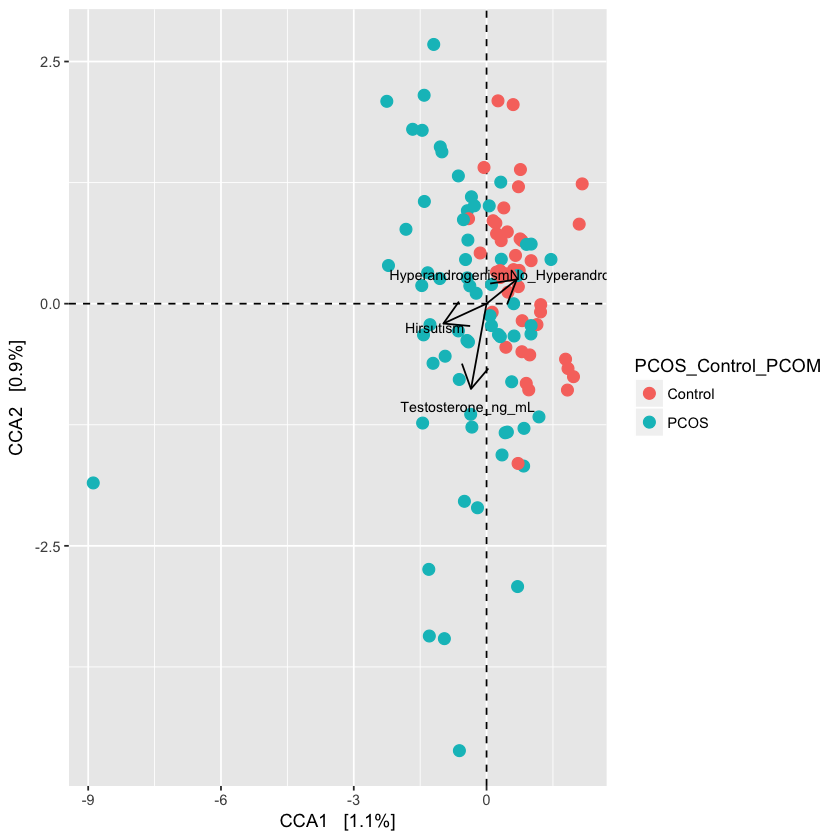

In [80]:
# Now add the environmental variables as arrows
arrowmat = vegan::scores(cca_lit, display = "bp")
# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)
# Define the arrow aesthetic mapping
arrow_map = aes(xend = CCA1, yend = CCA2, x = 0, y = 0, shape = NULL, color = NULL, 
                label = labels)
label_map = aes(x = 1.2 * CCA1, y = 1.2 * CCA2, shape = NULL, color = NULL, 
                label = labels)
# Make a new graphic
arrowhead = arrow(length = unit(0.05, "npc"))
p1 = p0 + geom_segment(arrow_map, size = 0.5, data = arrowdf, color = "black", 
                       arrow = arrowhead) + geom_text(label_map, size = 3, data = arrowdf)
p1

arrowdf = transform(arrowdf, radians = atan(CCA2/CCA1))
arrowdf = transform(arrowdf, angle = 360 * radians/(2 * pi))
# Quadrants II, III, IV
arrowdf$quad234 <- apply(arrowdf[, c("CCA1", "CCA2")], 1, function(x) {
  any(x < 0)
})
arrowdf$quad4 <- apply(arrowdf[, c("CCA1", "CCA2")], 1, function(x) {
  all(x < 0)
})

# What is different though? One approach is using random forest.

In [104]:
library(randomForest)
library(knitr)

#'Plot randomforest
#'
#' @author Pedro J. Torres \email{pjtorres88@gmail.com}
#'This function finds the top 10 features from a phyloseq object that have the greatest influence of classification accuracy using 
#randomforest and plots those features in a box plot
#'
#' @param physeq (Required). A \code{phyloseq} object containing merged information of abundance,
#'        taxonomic assignment, sample data including the measured variables and categorical information
#'        of the samples, and / or phylogenetic tree if available.
#' @param randomForest (Required)- do random forest
#' @param scales (Required)- will help with scaling of boxplot
#' @param grid (Required)- will help with scaling of boxplot
#' @param knitr (Required)- give a nice output of the important feature in a random foret model
#' @param stringr (Required)- allows modificaiton of important OTUS
#' @param repr (Required)- allows modificaiton of boxplot aka bigger plots!

#' @param grouping_column (Required). Character string specifying name of a categorical variable that is preffered for grouping the information.
#'        information, this should be one of the components of grouping vector.
#' @param  Color. What variable in your mapping file should determine the color of your box plots (Phylum,class, order ect..)
#' @param  Facet How your box plots will be split up

#' @examples
#' #plot the significant features
#' plot_randomforest(physeqobject,grouping_column='Treatment', Color='Family', Facet='Genus')
#'
#' This code was modified by Pedro J. Torres \email{pjtorres88@gmail.com} a number of phyloseq tutorials out there
#'
#'

plot_randomforest=function(physeq, grouping_column,Color,Facet){
    
    #filter out any taxa with a zero or in very low abudnace and prep for random forest, will not make training set here
    physeq_0_filtered <- prune_taxa(taxa_sums(physeq) > 0,physeq)
    physeq_10_filtered <- prune_taxa(taxa_sums(physeq_0_filtered)>5,physeq_0_filtered)
    #predictors <- t(otu_table(physeq_10_filtered))
    predictors <- otu_table(physeq_10_filtered)


    physeq_10_filtered_sample_Data <- data.frame(sample_data(physeq_10_filtered))
    physeq_10_filtered_sample_Data$Groups <- physeq_10_filtered_sample_Data[,grouping_column]
    response <- as.factor(physeq_10_filtered_sample_Data$Groups)
    rf.data <- data.frame(response,predictors)
    
    # run random forest
    set.seed(123)
    physeq_10_filtered_Classify <- randomForest(response~., data = rf.data, ntree = 1000)
    print(physeq_10_filtered_Classify)
    
    imp <- importance(physeq_10_filtered_Classify)
    imp <- data.frame(predictors = rownames(imp), imp)
    attach(imp)

    # sort by mpg
    imp.sort <- imp[order(-MeanDecreaseGini),] 
    #imp.sort <- arrange(imp, desc(MeanDecreaseGini))
    imp.sort$predictors <- factor(imp.sort$predictors, levels = imp.sort$predictors)

    imp.20 <- imp.sort[1:10, ]
    
    p=ggplot(imp.20, aes(x = predictors, y = MeanDecreaseGini)) +
      geom_bar(stat = "identity", fill = "indianred") + 
      coord_flip() +
      ggtitle("Most important OTUs for classifying ")
    print (p)
    
    #-----What are those OTUs?
    otunames <- imp.20$predictors
    otunames=gsub('X', '', otunames)
    r <- rownames(tax_table(physeq_10_filtered)) %in% otunames
    table=kable(tax_table(physeq_10_filtered)[r, ])
    print(table)

    #subset 10 most important variables
    lsvs=c(otunames)

    #generate boxplot===========================================
      
    #convert physeq to dataframe
    physeq_10_filtered = transform_sample_counts(physeq_10_filtered, function(x) x/sum(x))
    mphyseq = psmelt(physeq_10_filtered)
    mphyseq<- mphyseq[mphyseq$OTU %in% lsvs,]

    #plot
    options(repr.plot.width=20, repr.plot.height=15)
    prf=ggplot(data = mphyseq,  mapping = aes_string(x = grouping_column, y = "Abundance",
                                 color = Color, fill = Color)) +
        geom_boxplot(fill = NA) +
        geom_point(size = 1.7, alpha = 1,
                    position = position_jitter(width = 0.3)) +
       facet_wrap(facets = Facet) + ylab('Relative Abundance') +
       scale_y_log10()+theme(axis.text.x = element_text(angle = 90, hjust = 1))
    
    print (prf)

}

In [101]:
# Filter out PCOM again but from raw data
physeq_P.C=subset_samples(physeq, PCOS_Control != 'PCOM')


Call:
 randomForest(formula = response ~ ., data = rf.data, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 21

        OOB estimate of  error rate: 40.52%
Confusion matrix:
        Control PCOS class.error
Control       7   40   0.8510638
PCOS          7   62   0.1014493


The following object is masked _by_ .GlobalEnv:

    predictors

The following objects are masked from imp (pos = 4):

    MeanDecreaseGini, predictors





|                                 |Kingdom     |Phylum            |Class                    |Order                |Family                |Genus            |Species        |
|:--------------------------------|:-----------|:-----------------|:------------------------|:--------------------|:---------------------|:----------------|:--------------|
|ec530b03a10904478dd9b5287d4d2a3b |k__Bacteria |p__Firmicutes     |c__Clostridia            |o__Clostridiales     |f__Lachnospiraceae    |g__Blautia       |s__            |
|a76563e6b57168beb9509f4e5707eec4 |k__Bacteria |p__Firmicutes     |c__Clostridia            |o__Clostridiales     |f__Lachnospiraceae    |g__Roseburia     |NA             |
|865d0eb384786f5727fbf9ef379ba252 |k__Bacteria |p__Firmicutes     |c__Clostridia            |o__Clostridiales     |f__[Tissierellaceae]  |g__WAL_1855D     |s__            |
|d5a81c064f652fec66095ad3953edfd6 |k__Bacteria |p__Proteobacteria |c__Epsilonproteobacteria |o__Campylobacterales |f__Campylobacterac

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 698 rows containing non-finite values (stat_boxplot).”

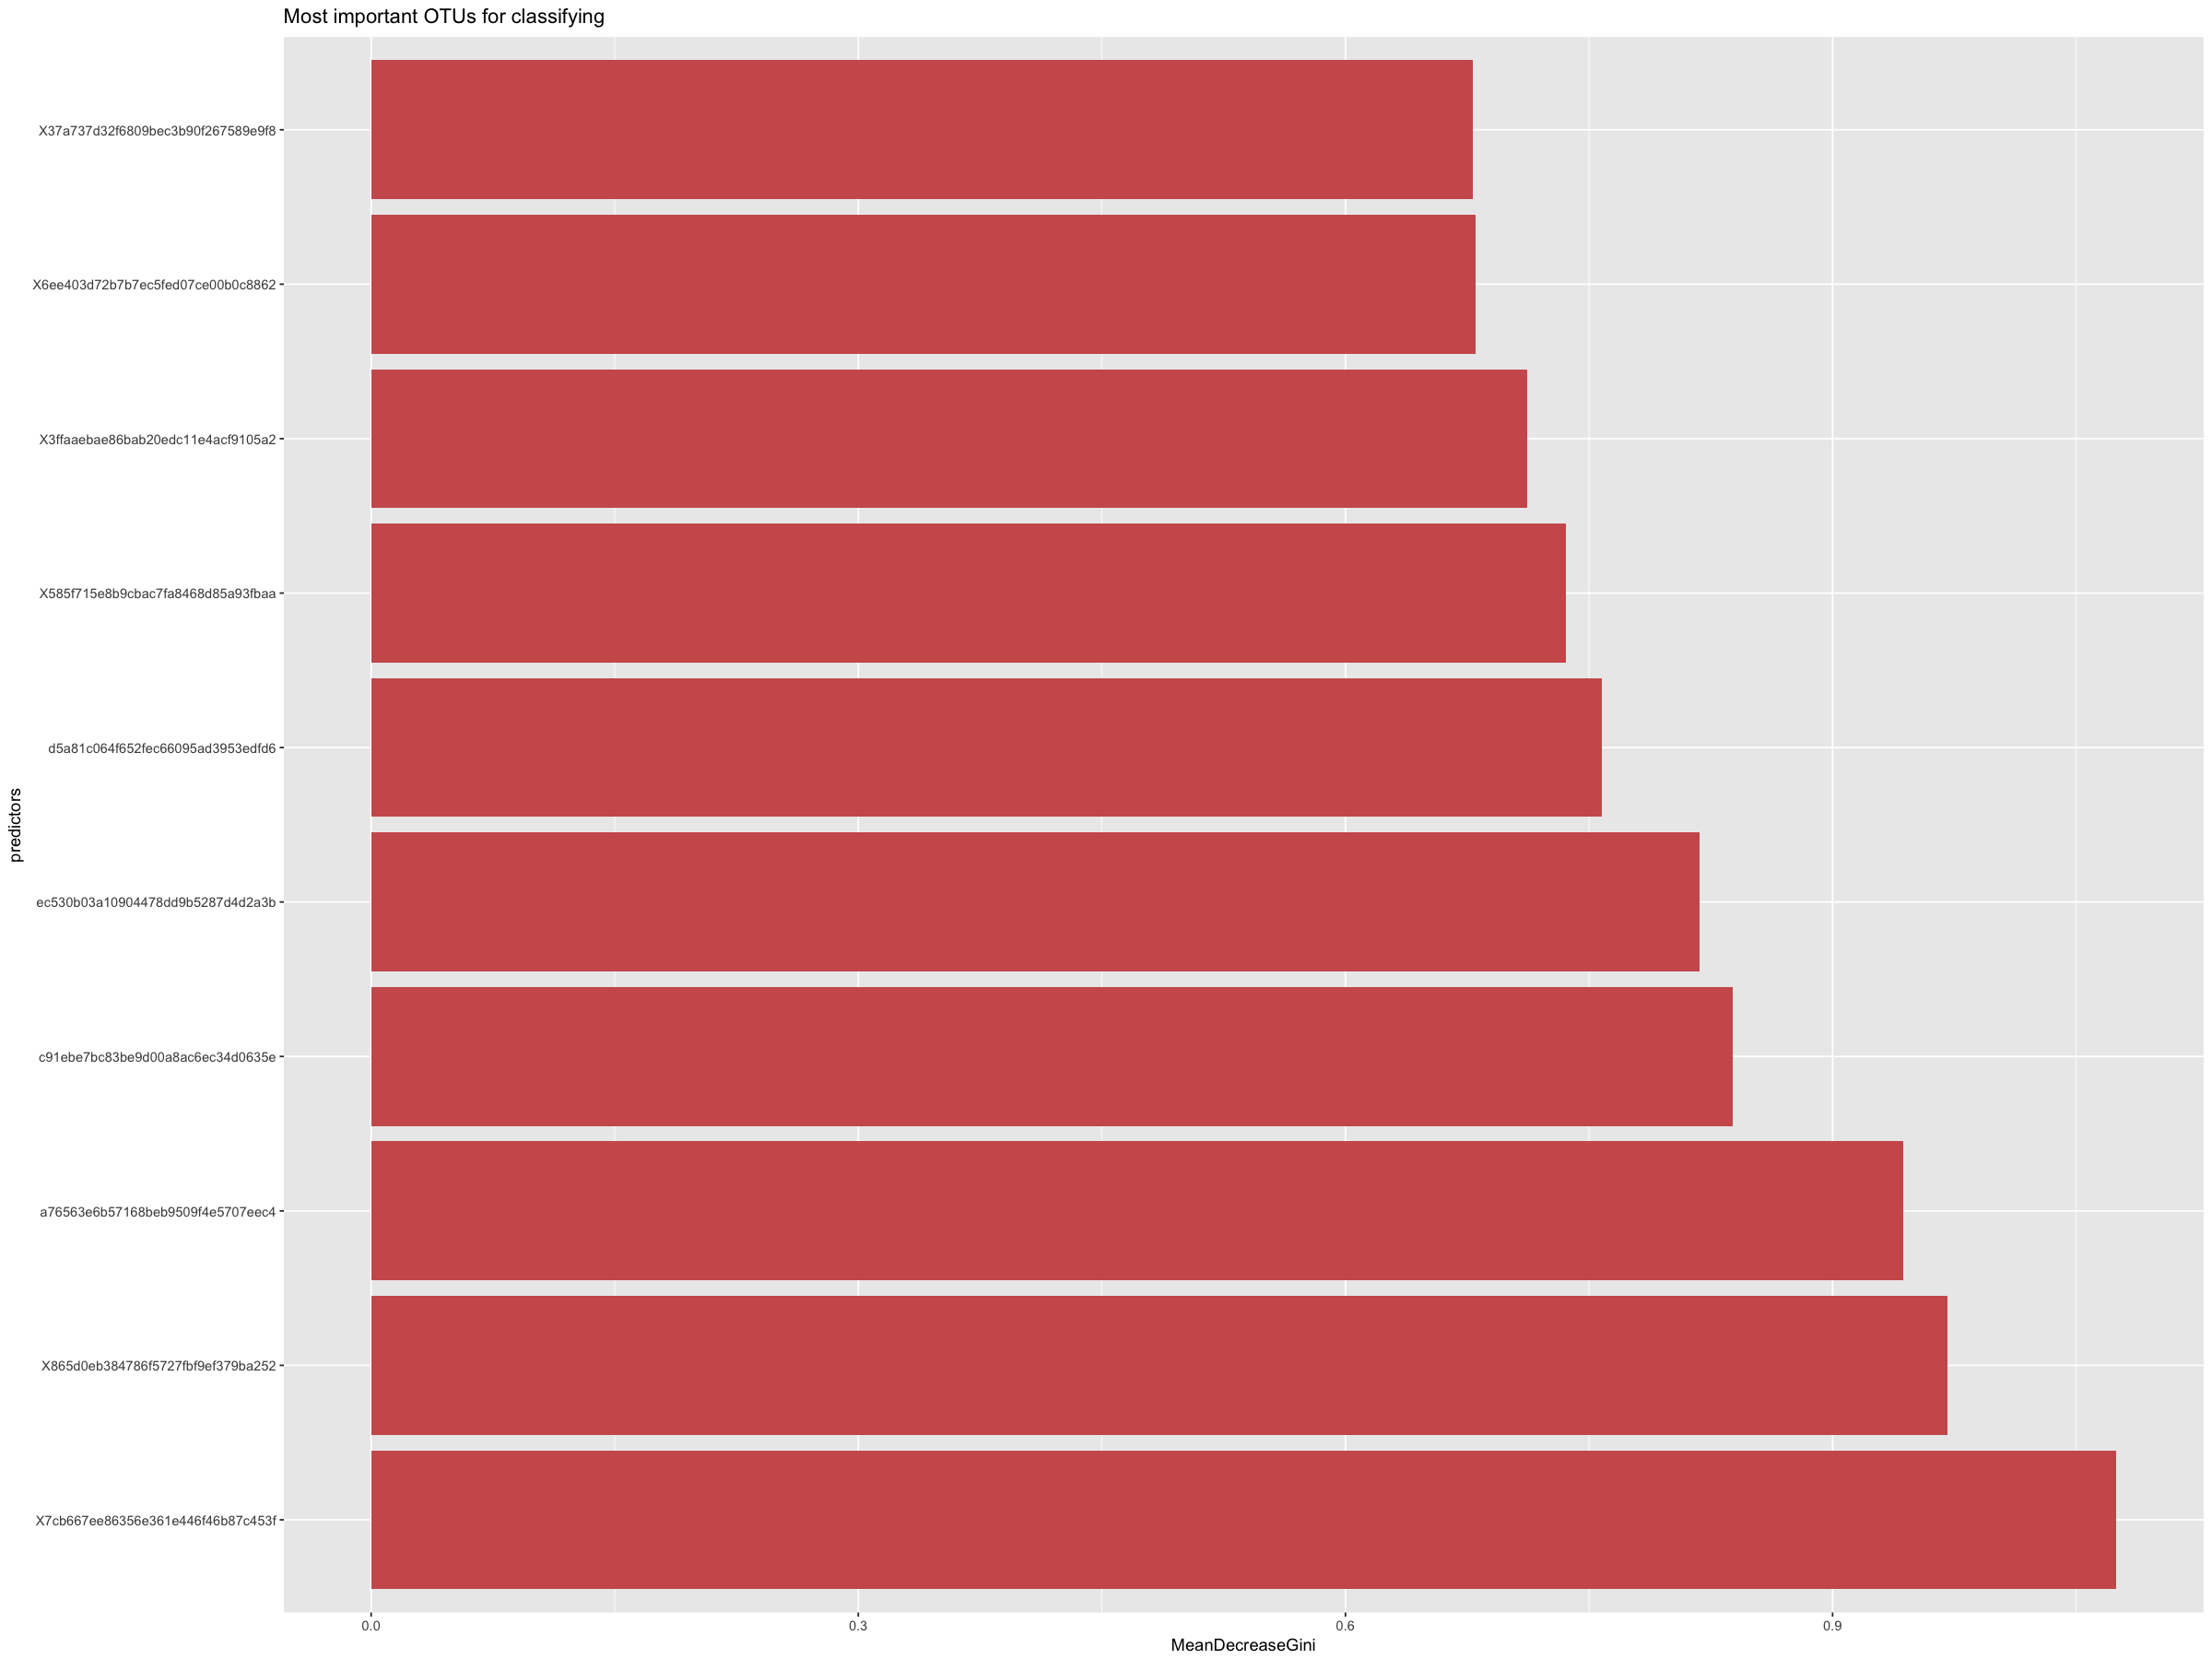

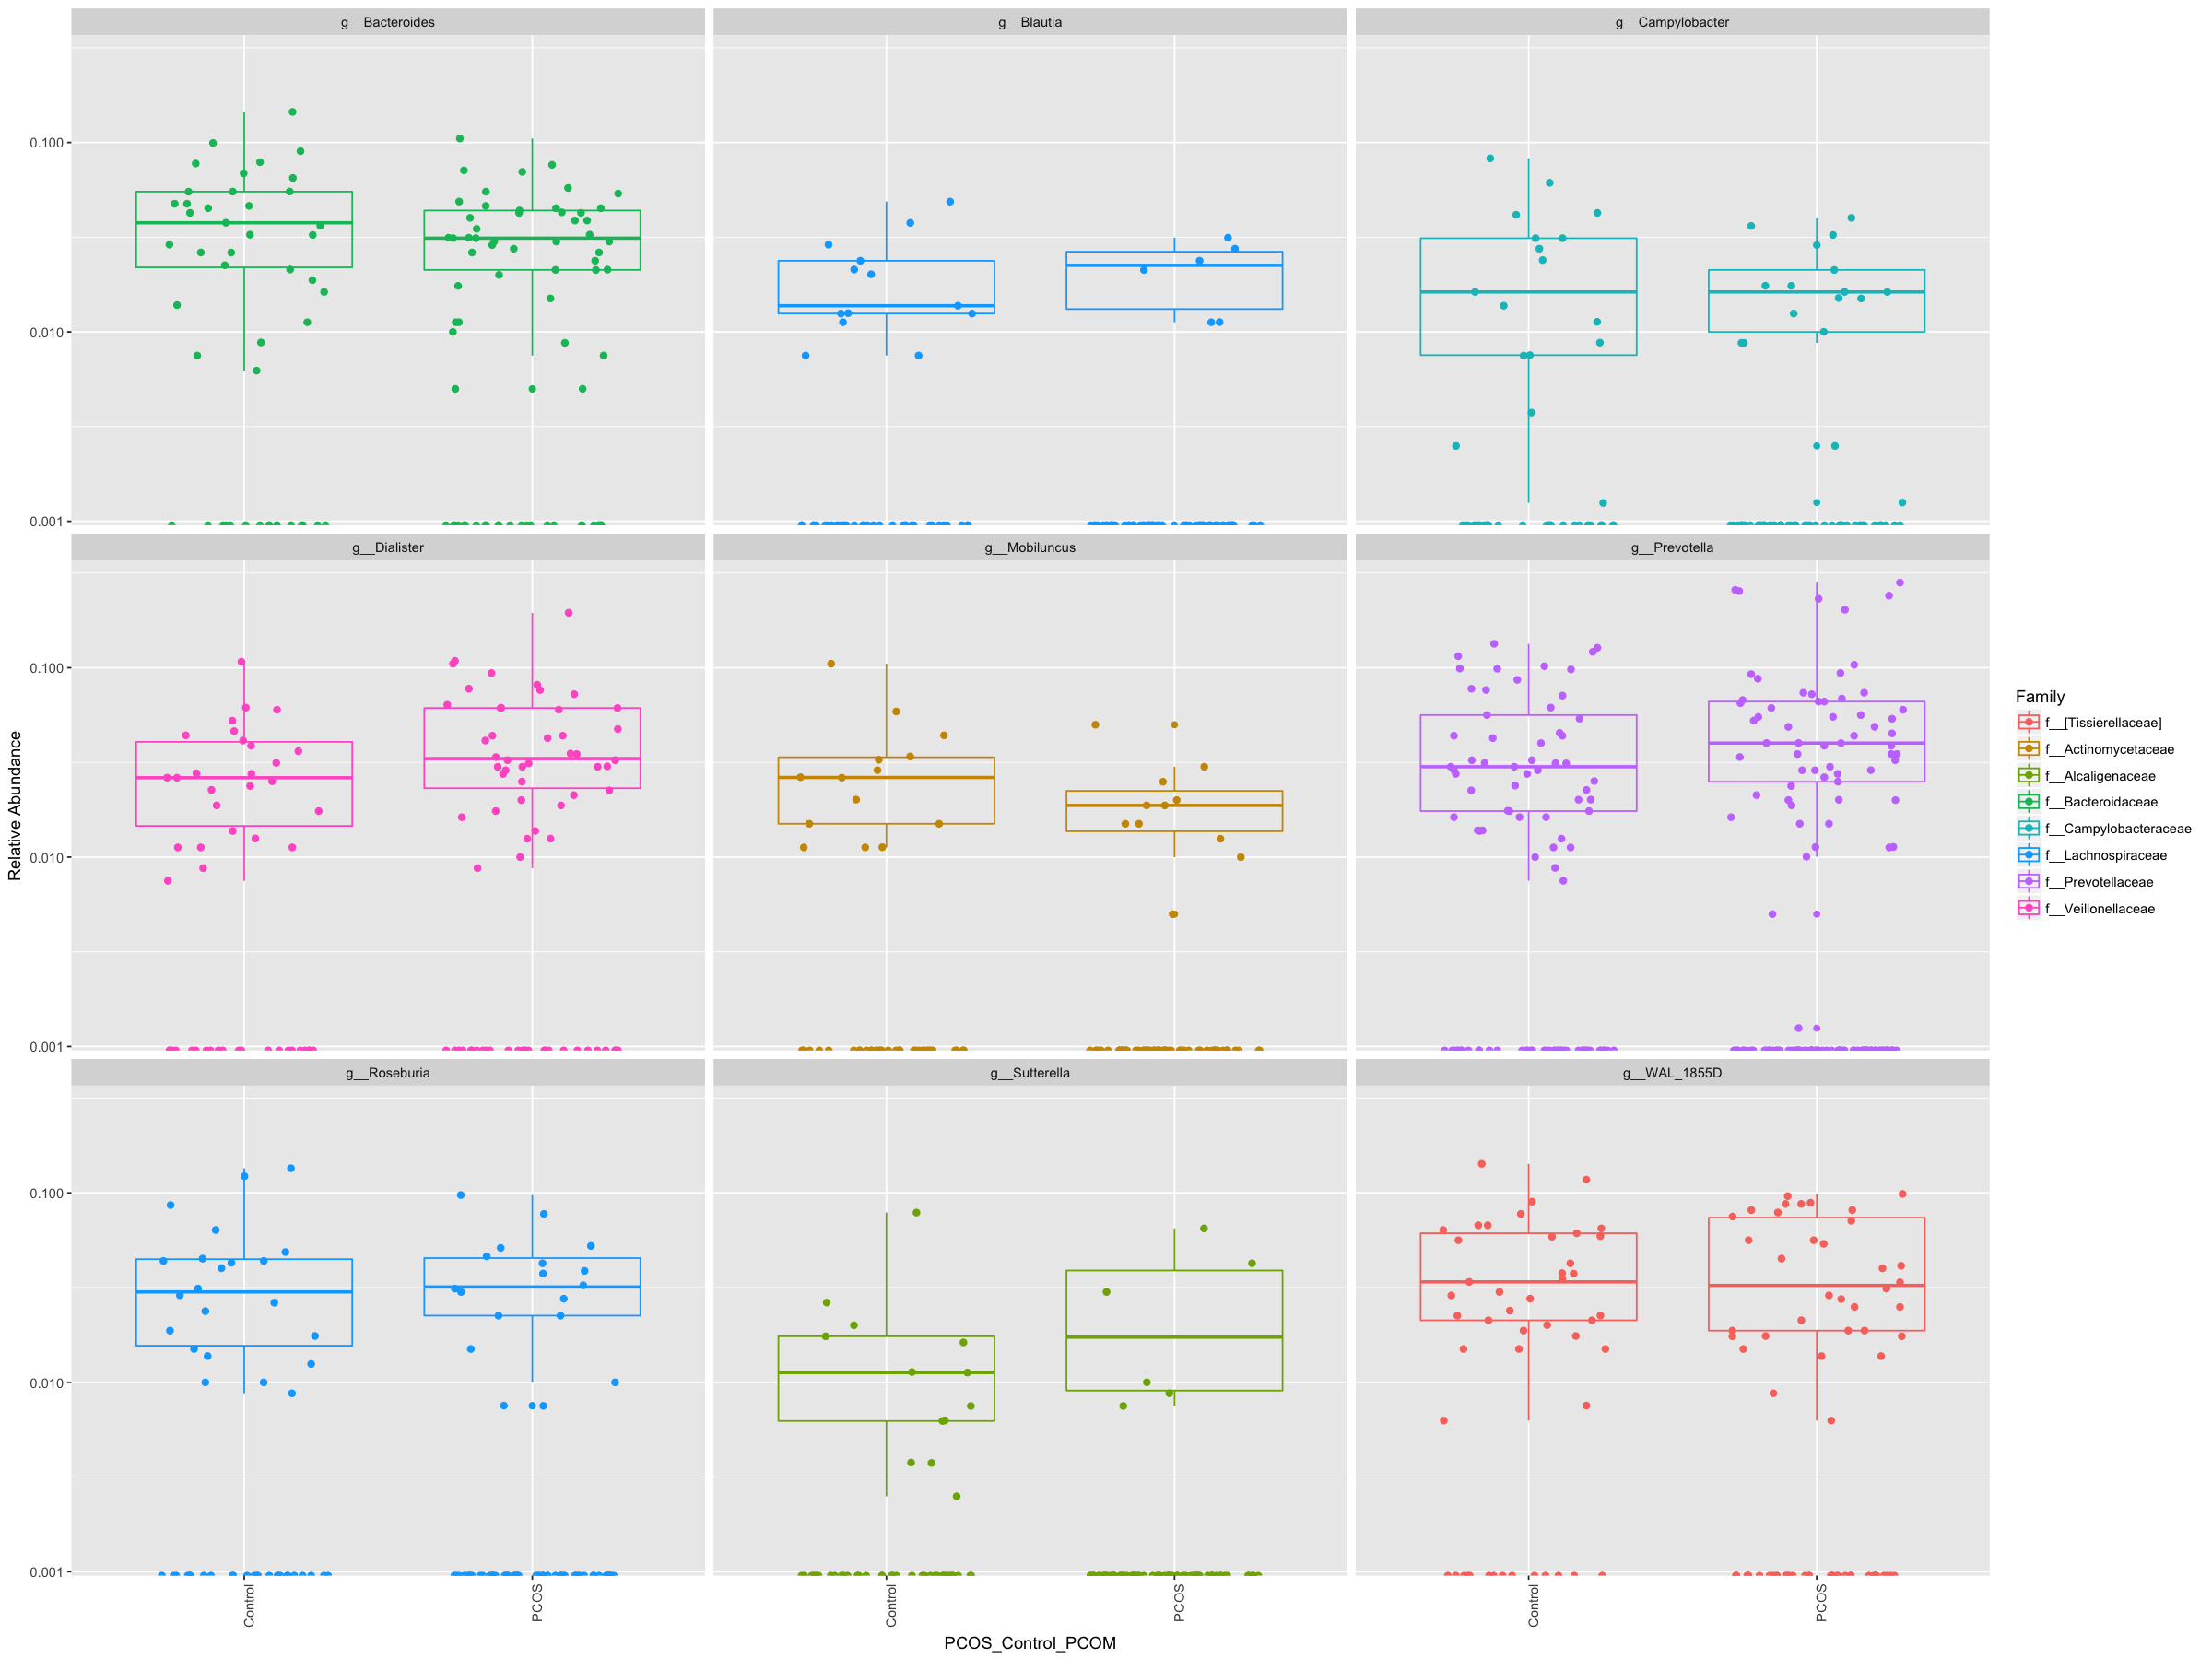

In [105]:
plot_randomforest(physeq_P.C,grouping_column='PCOS_Control_PCOM', Color='Family', Facet='Genus')

# if this command does not work then got to line 35 and remove the '#' and add that to line 36
# aka do not transform

# There you go! 
